# 1.4 RBIG Model

In [17]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])

# append to path
sys.path.append(str(here()))
# jax packages
import jax
import jax.numpy as np
from jax.config import config
import chex
config.update("jax_enable_x64", True)

import numpy as onp
from functools import partial

# library parameters
from rbig_jax.data import get_classic
from rbig_jax.plots import plot_info_loss, plot_joint, plot_joint_prob

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Logging

In [18]:
wandb.init(project="rbigjax-demo-2d", entity="emanjohnson91")


In [19]:

# config parameters
wandb.config.n_samples = 1_000
wandb.config.dataset = "classic"
wandb.config.method = "histogram"
wandb.config.support_extension = 10
wandb.config.precision = 50
wandb.config.alpha = 0.0
wandb.config.n_layers = 20

## Data

<Figure size 432x288 with 0 Axes>

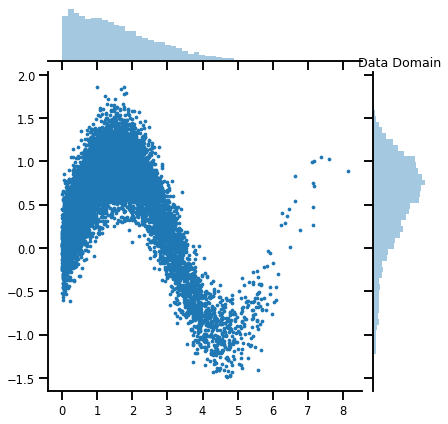

In [20]:
# %%wandb
# get data
data = get_classic(10_000)

# plot data
plt.figure()
sns.jointplot(data[:, 0], data[:, 1], s=5)
plt.title('Data Domain')
plt.show()

## Initialization

First we need to initialize our RBIG method with some parameters. For example, which marginal gaussianization method, what precision do we want, and what rotation method do we want.

* `method` - the method used to marginally transform the data. We have histogram or kde currently implemented
* `support_extension` - this is the amount we want to extend the support for our marginal distributions. Higher values indicate higher
* `precision` - we use interpolation because it is much faster. So the CDF, PDF and PPF are interpolation schemes. This value will allow one to have more "precision" for the estimated quantities but it will be slower.

In [21]:
from rbig_jax.transforms.histogram import get_hist_params
from rbig_jax.transforms.uniformize import uniformize_transform
from rbig_jax.transforms.marginal import marginal_transform_params, marginal_transform
from rbig_jax.transforms.gaussianize import gaussianize_forward
from rbig_jax.transforms.gaussianize import gaussianize_marginal_transform, gaussianize_marginal_inverse

## RBIG MODEL

In [32]:
import objax
from typing import Callable, Optional
from rbig_jax.transforms.rbig import (
    rbig_block_forward, 
    rbig_block_inverse, 
    rbig_block_transform, rbig_block_transform_gradient
)
from rbig_jax.information.total_corr import get_tolerance_dimensions, information_reduction

class RBIGFlow:
    def __init__(
        self,
        gaussianize_f: Optional[Callable] = None,
        uni_ent_est: Optional[Callable] = None,
        p: int = 0.25,
        n_samples: int = 10_000,
        max_layers: int = 1_000,
        jitted: bool = True,
    ):
        # create Gaussinization block
        self.block_forward = jax.partial(
            rbig_block_forward, marginal_gauss_f=gaussianize_f
        )
        self.block_transform = rbig_block_transform
        self.block_inverse = rbig_block_inverse
        self.block_gradient = rbig_block_transform_gradient
        self.max_layers = max_layers

        # INFORMATION THEORY LOSS
        tol_dims = get_tolerance_dimensions(n_samples)
        self.uni_ent_est = uni_ent_est
        self.loss_f = jax.partial(
            information_reduction, uni_entropy=self.uni_ent_est, tol_dims=tol_dims, p=p
        )

        # jit arguments (much faster!)
        if jitted:
            self.block_forward = jax.jit(self.block_forward)
            self.block_transform = jax.jit(self.block_transform)
            self.block_inverse = jax.jit(self.block_inverse)
            self.block_gradient = jax.jit(self.block_gradient)
            self.loss_f = jax.jit(self.loss_f)

    def fit(self, X):

        _ = self.fit_transform(X)

        return self

    def fit_transform(self, X):

        self.n_features = X.shape[1]

        # initialize parameter storage
        params = []
        losses = []
        i_layer = 0

        # loop through
        while i_layer < self.max_layers:

            loss = jax.partial(self.loss_f, X=X)

            # fix info criteria
            X, block_params = self.block_forward(X)

            info_red = loss(Y=X)

            # append Parameters
            params.append(block_params)
            losses.append(info_red)

            i_layer += 1

        self.n_layers = i_layer
        self.params = params
        self.info_loss = np.array(losses)
        return X

    def transform(self, X):

        for iparams in self.params:
            X = self.block_transform(X, iparams)
        return X

    def inverse_transform(self, X):
        for iparams in self.params[::-1]:
            X = self.block_inverse(X, iparams)
        return X

    def log_det_jacobian(self, X):
        X_ldj = np.zeros_like(X)

        # loop through params
        for iparams in self.params:
            X, log_det = self.block_gradient(X, iparams)
            X_ldj += log_det

        return X_ldj

    def score_samples(self, X):
        X_ldj = np.zeros_like(X)

        # loop through params
        for iparams in self.params:
            X, log_det = self.block_gradient(X, iparams)
            X_ldj += log_det

        # calculate log probability
        latent_prob = jax.scipy.stats.norm.logpdf(X)

        # log probability
        log_prob = (latent_prob + X_ldj).sum(-1)

        return log_prob

    def score(self, X):
        return self.score_samples(X).mean()

    def sample(self, n_samples: int):

        X_gauss = objax.random.normal((n_samples, self.n_features))
        return self.inverse_transform(X_gauss)

    def total_correlation(self, base: int = 2) -> np.ndarray:
        return np.sum(self.info_loss) * np.log(base)

    def entropy(self, X: np.ndarray, base: int = 2) -> np.ndarray:
        return self.uni_ent_est(X).sum() * np.log(base) - self.total_correlation(base)



### Fit

In [40]:
# marginal Gaussianization parameters
n_samples = data.shape[0]
support_extension = 10
alpha = 1e-5
precision = 100
nbins = int(np.sqrt(n_samples))
return_params = True

uniformize_transform = jax.partial(
    get_hist_params,
    nbins=nbins,
    support_extension=support_extension,
    precision=precision,
    alpha=alpha,
    return_params=return_params,
)

uni_transform_f = jax.partial(
    marginal_transform_params, function=uniformize_transform
)

gaussianize_f = jax.partial(gaussianize_forward, uni_transform_f=uni_transform_f)

# ENTROPY
from rbig_jax.information.entropy import histogram_entropy
nbins = int(np.sqrt(n_samples))
entropy_f = jax.partial(histogram_entropy, nbins=nbins, base=2)


In [41]:
%%time

max_layers = 30
jitted = True      # much faster!

# initialize RBIG Class
rbig_clf = RBIGFlow(gaussianize_f, entropy_f, max_layers, jitted)

# fit RBIG class
X_g = rbig_clf.fit_transform(data)

CPU times: user 17.9 s, sys: 2.1 s, total: 20 s
Wall time: 10.1 s


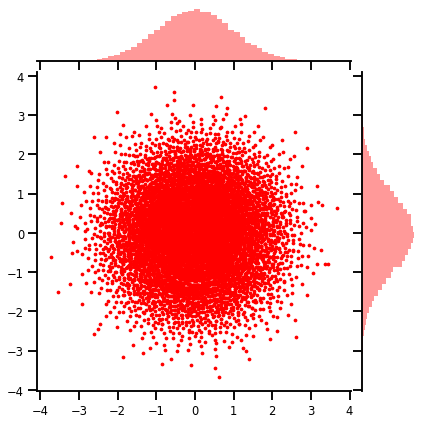

In [42]:
sns.jointplot(X_g[:, 0], X_g[:, 1], s=5, color='red')

### Forward Transformation

In [43]:
%%time
X_g = rbig_clf.transform(data)

CPU times: user 8.91 s, sys: 1.15 s, total: 10.1 s
Wall time: 1.7 s


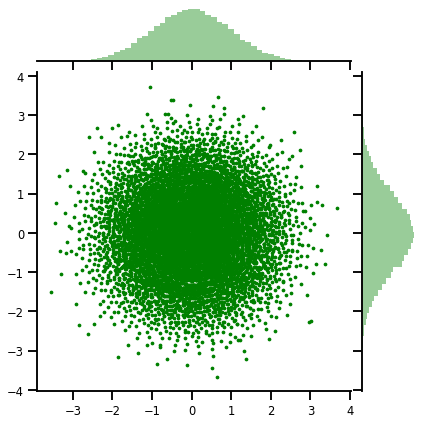

In [44]:
sns.jointplot(X_g[:, 0], X_g[:, 1], s=5, color='green')

### Inverse Transformation

In [45]:
%%time
X_approx = rbig_clf.inverse_transform(X_g)

CPU times: user 5.53 s, sys: 1.76 s, total: 7.29 s
Wall time: 3.17 s


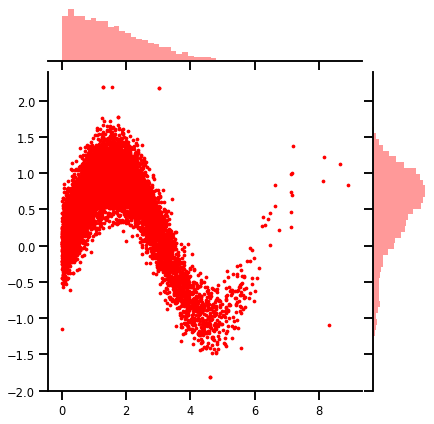

In [46]:
sns.jointplot(X_approx[:, 0], X_approx[:, 1], s=5, color='red')

### Sampling

In [47]:
%%time
X_samples = rbig_clf.sample(100_000)

CPU times: user 1min, sys: 12.5 s, total: 1min 13s
Wall time: 15.7 s


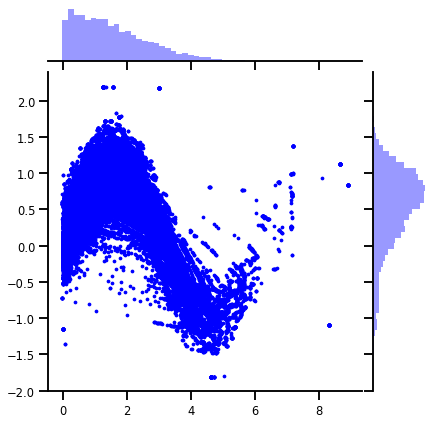

In [48]:
sns.jointplot(X_samples[:, 0], X_samples[:, 1], s=5, color='blue')

## Pro